In [45]:
import tensorflow as tf
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsClassifier
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import operator
import scipy as sp
from sklearn import preprocessing
import json
import pandas as pd
from scipy.stats import gamma
from math import log2
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
DESIRED_SPECIES = "AT"

In [48]:
def data_location(main_path,data, proteins):
  array = []
  for protein in proteins:
    array.append(str(main_path+data+protein))
  return array
AT_original = "/content/drive/MyDrive/DistanceClassifier/data/ATOriginal"

In [49]:

classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'Original', 'SF', 'SFDD'] #Sticky, HGG
data_proteins = data_location("/content/drive/MyDrive/DistanceClassifier/data/", DESIRED_SPECIES, classes)

In [50]:
def combine_data(data_location):
  df_comb = pd.DataFrame()
  for protein in data_location:
    df = pd.read_csv(protein, header = None, sep = ' ')
    df['class'] = protein[49:]
    df_comb = pd.concat([df, df_comb])
  return df_comb

In [51]:
df_comb = combine_data(data_proteins)
df_comb = df_comb.sample(frac=1).reset_index(drop=True)
df_class = df_comb['class']
df_comb = df_comb.drop("class", axis = 1)
df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
df_comb['class'] = df_class.reset_index(drop = True)

In [52]:
df_comb.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,class
0,1.000000,0.251051,0.004130,0.245338,0.054621,0.002638,0.012284,0.000606,0.000007,0.084754,...,2.355137e-03,0.000654,0.000041,0.000342,0.000098,0.000021,0.000005,9.512184e-07,1.301155e-08,SF
1,0.334570,0.283086,0.027724,0.316683,0.026261,0.110375,0.018966,0.006800,0.000076,0.164904,...,2.190832e-02,0.010942,0.000047,0.001007,0.006981,0.000099,0.000293,8.459050e-06,1.366213e-07,SFDD
2,0.221424,0.306365,0.931066,0.504303,0.023232,0.058863,0.948325,0.274965,0.898907,0.289640,...,7.848234e-01,0.100846,0.925179,0.131036,0.111718,0.808108,0.007756,5.875292e-02,8.740767e-01,ERDD
3,0.518665,0.001857,0.203930,0.000543,0.000007,0.000549,0.010161,0.018048,0.006947,0.000055,...,5.916009e-04,0.000839,0.000239,0.002810,0.000137,0.001801,0.000165,6.656604e-04,2.032209e-04,GEO
4,0.303269,0.053877,0.000068,0.026594,0.001078,0.000007,0.000016,0.000000,0.000000,0.004728,...,2.594416e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,ER


In [53]:
df_comb['class'].value_counts()

SFDD        500
ERDD        500
GEOGD       500
SF          499
GEO         499
ER          499
Original      1
Name: class, dtype: int64

In [54]:
def NearNeigh_PL(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance) 

In [55]:
def single_NearNeigh_PL(data_dict, orig):
    array = []
    temp_array = []
    for label in classes:
      data = data_dict[label]
      for i in data:
        temp = (data_orig.values - i)**2
        d = np.sqrt(np.sum(temp,axis=1))
        temp_array.append(d.min)

    return temp_array

In [56]:
def specific_class(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

In [64]:
nearest_dict = {}
classes= ['ER', 'ERDD', 'GEO', 'GEOGD', 'SF', 'SFDD']
for target in classes:
  nearest_dict[target] = NearNeigh_PL(specific_class(df_comb[df_comb['class'] != 'Original'], target))

In [65]:
nearest_dict.keys()

dict_keys(['ER', 'ERDD', 'GEO', 'GEOGD', 'SF', 'SFDD'])

In [66]:
def arctan(x, x0, k):
    m = (2/np.pi)*np.arctan(k*(x-x0))
    return m

In [67]:
def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)

In [68]:
def tanh(x, x0, k): # for log curve_fit
    m = (1+np.tanh(k*(x-x0)))/2
    return m

In [69]:
def plot_empirical_CDF(data, Density):
    fig = plt.figure()
    h = plt.hist(data,bins=len(data),density=Density,cumulative=True,histtype='stepfilled')    # bins set to equal to # of empirical data
    x = h[1][:-1]
    y = h[0]
    plt.close(fig)
    return x,y

def curve_fitter(data_NN, x, y, func):
    p0 = [np.median(data_NN),1] # this is initial guess for curve_fit()
    popt, pcov = curve_fit(f=func, xdata=x, ydata=y, p0=p0,method='lm', maxfev = 10000000)

    # parameters yielded by Curve_fit: x0, k
    print(popt)
    return popt

def sig_plot(data_dict, suptitle, func):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(2,4, figsize = (30, 12))
    ax = ax.ravel()
    f.suptitle(suptitle)
    intervals = [0,1,2,3,4,5,6,7]
    for key,value,i in zip(data_dict.keys(), data_dict.values(), intervals):
      # x, y = sigmoid_calc(value, logistic)
      x, y = plot_empirical_CDF(value, True)
      popt = curve_fitter(value, x, y, func)
      y = func(x,*popt)
      ax[i].plot(x,y)
      ax[i].set_title(key)
    plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[-0.62894411 44.29318059]
[2.83905949e-02 8.15479795e+01]
[7.42824758e-04 2.24965781e+03]
[9.22682869e-04 2.40345179e+02]
[-0.20105387 84.21408651]
[ 0.03756085 32.31230131]


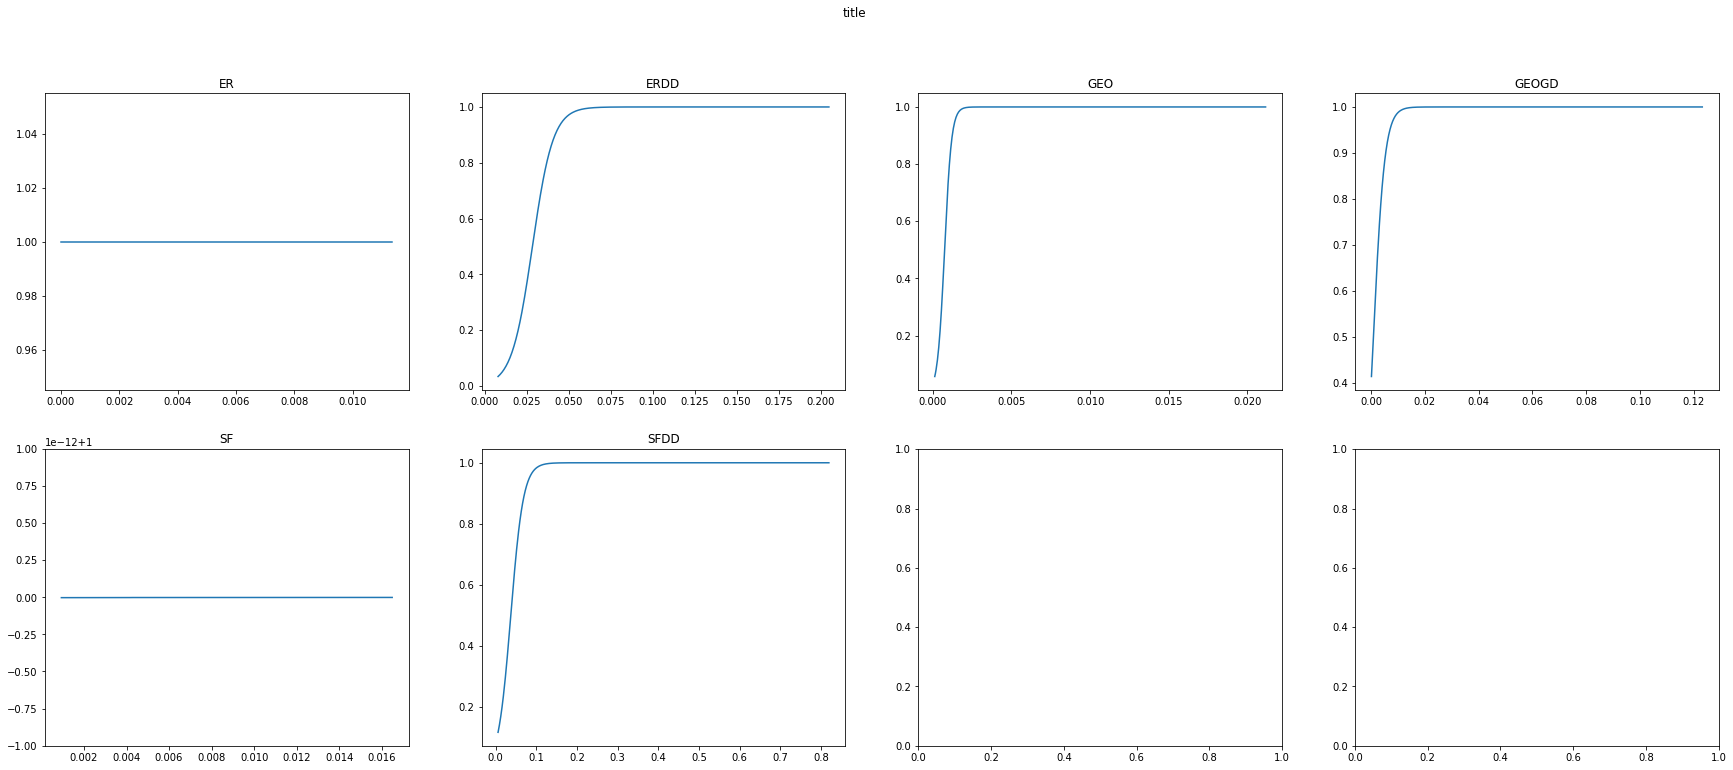

In [70]:
sig_plot(nearest_dict, 'title', tanh)

In [88]:
def single_NearNeigh_PL(data_dict, orig):
  array = []
  temp_array = []
  for label in classes:
    data = data_dict[label].values
    for i in data:
      temp_array.append(np.linalg.norm(i-original.values))
    array.append(temp_array)
    temp_array = []

  small_arr = []
  smallest = 1e13;
  for arr in array:
    small_arr.append(min(array))
  return small_arr

In [102]:
UniqueNames = df_comb['class'].unique()
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_comb[:][df_comb['class'] == key]

for key in DataFrameDict:
  DataFrameDict[key] = DataFrameDict[key].drop('class', axis = 1)

In [113]:
DataFrameDict['ERDD']

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
2,0.221424,0.306365,0.931066,0.504303,0.023232,0.058863,0.948325,0.274965,0.898907,0.289640,...,0.001216,0.784823,0.100846,0.925179,0.131036,0.111718,0.808108,0.007756,0.058753,0.874077
9,0.204266,0.299670,0.927262,0.488959,0.022160,0.054578,0.916960,0.258648,0.898595,0.279991,...,0.001063,0.723925,0.087033,0.898907,0.117333,0.101945,0.759606,0.007160,0.056516,0.874015
19,0.249478,0.304060,0.979285,0.492893,0.022509,0.053726,0.966641,0.285307,0.966367,0.279066,...,0.000991,0.729394,0.100769,0.963996,0.129269,0.104912,0.848185,0.008176,0.067847,0.956726
29,0.268259,0.307844,0.985839,0.503500,0.023036,0.057788,0.965211,0.373449,0.953679,0.286941,...,0.001161,0.723048,0.158453,0.943902,0.190548,0.150435,0.797711,0.030089,0.276895,0.910760
30,0.244841,0.302560,0.973581,0.490680,0.022284,0.053750,0.957047,0.257347,0.964532,0.279729,...,0.001025,0.728991,0.081949,0.961497,0.113804,0.098411,0.773878,0.006803,0.055106,0.956271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,0.210526,0.302846,0.927926,0.494160,0.022751,0.054757,0.932389,0.260988,0.898506,0.282253,...,0.001069,0.726769,0.088407,0.913615,0.122360,0.102121,0.767192,0.007594,0.055882,0.873979
2974,0.268259,0.318528,0.935079,0.534642,0.024904,0.075623,0.933210,0.596728,0.822589,0.309922,...,0.001989,0.719065,0.324982,0.821730,0.366489,0.275112,0.794554,0.197624,0.672090,0.690298
2977,0.268259,0.339049,0.835896,0.600158,0.028597,0.145271,0.882126,0.920894,0.590184,0.358826,...,0.006584,0.885305,0.664989,0.599540,0.802862,0.736652,0.937947,0.774918,0.976741,0.366004
2979,0.268259,0.317734,0.930077,0.534930,0.024626,0.084086,0.913638,0.663037,0.797010,0.311299,...,0.002500,0.735889,0.378970,0.777722,0.437394,0.337512,0.831169,0.269223,0.758996,0.645726


In [118]:
# array = []
# temp_array = []
# for label in classes:
#   data = data_dict[label].values
#   for i in data:
#     temp_array.append(np.linalg.norm(i-data_orig.values))
#   array.append(temp_array)
#   temp_array = []

def smallest_in_arr(euclid_list):
  small_arr = []
  smallest = 1e13;
  for array in euclid_list:
    small_arr.append(min(array))
  return small_arr

# nearest_orig = smallest_in_arr(array)

In [115]:
original = df_comb[df_comb['class'] == 'Original'].drop('class', axis = 1)
nearest_orig = single_NearNeigh_PL(DataFrameDict, original)

In [119]:
smallest_in_arr(nearest_orig)

[1.7968583394945536,
 1.7968583394945536,
 1.7968583394945536,
 1.7968583394945536,
 1.7968583394945536,
 1.7968583394945536]

In [120]:
val1 = [2.83905949e-02, 7.42824758e-04, 9.22682869e-04]
val2 = [8.15479795e+01, 2.24965781e+03, 2.40345179e+02]
p_values = []
for i,j,k in zip(val1, val2, nearest_orig):
  print(tanh(k, i, j))

TypeError: ignored